In [1]:
from ipynb.fs.full.functions import (getPatientData,
getCancerPixels,
getCombinedCancerMask,
getDistsWBoundary,
splitModalityPixel,
evaluate)

from sklearn.model_selection import KFold
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np

## Get Patients

In [2]:
[patients, numPatients, numPatientsWithTumor] = getPatientData()
patients = np.array([item for item in patients if item["patientID"] != "P00000249"])

## Get Distributions

In [3]:
adcCancerPixels, adcNonCancerPixels, cdiCancerPixels, cdiNonCancerPixels = splitModalityPixel(patients)
    
x_adc, y_adc_cancer, y_adc_non_cancer, adc_threshold = getDistsWBoundary(adcCancerPixels,adcNonCancerPixels)
x_cdi, y_cdi_cancer, y_cdi_non_cancer, cdi_threshold_log = getDistsWBoundary(np.log(cdiCancerPixels[cdiCancerPixels>0]),
                                                                             np.log(cdiNonCancerPixels[cdiNonCancerPixels>0]))

## Plot Distributions

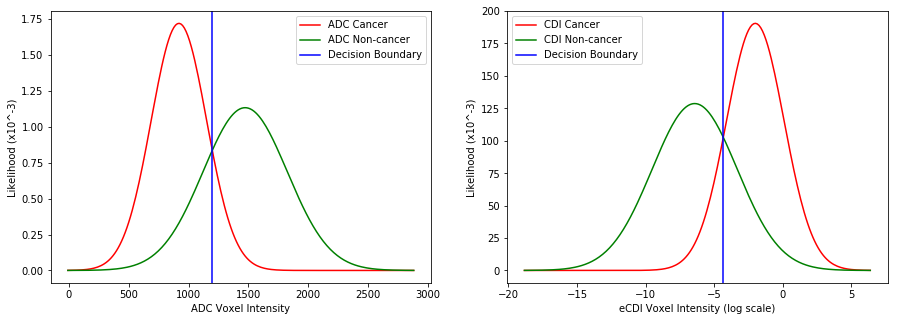

In [4]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(x_adc,y_adc_cancer*1000,c='r')
ax[0].plot(x_adc,y_adc_non_cancer*1000,c='g')
ax[0].axvline(x=adc_threshold,c='b')
ax[0].set_xlabel("ADC Voxel Intensity")
ax[0].set_ylabel("Likelihood (x10^-3)")
ax[0].legend(["ADC Cancer","ADC Non-cancer","Decision Boundary"])

ax[1].plot(x_cdi,y_cdi_cancer*1000,c='r')
ax[1].plot(x_cdi,y_cdi_non_cancer*1000,c='g')
ax[1].axvline(x=cdi_threshold_log,c='b')
ax[1].set_xlabel("eCDI Voxel Intensity (log scale)")
ax[1].set_ylabel("Likelihood (x10^-3)")
ax[1].legend(["CDI Cancer","CDI Non-cancer","Decision Boundary"])

#plt.savefig("distribution.png")
plt.show()

## K-Fold Training

In [5]:
adc_confusion_matrix_sum = np.zeros(shape=(2,2))
cdi_confusion_matrix_sum = np.zeros(shape=(2,2))

kf = KFold(n_splits=5, shuffle=False)

for num, (patients_train_index, patients_test_index) in enumerate(kf.split(patients)):
    print('Trial {}\n'.format(num+1))
    
    adcCancerPixels, adcNonCancerPixels, cdiCancerPixels, cdiNonCancerPixels = splitModalityPixel(patients[patients_train_index])
    
    x_adc, y_adc_cancer, y_adc_non_cancer, adc_threshold = getDistsWBoundary(adcCancerPixels,adcNonCancerPixels)
    x_cdi, y_cdi_cancer, y_cdi_non_cancer, cdi_threshold_log = getDistsWBoundary(np.log(cdiCancerPixels[cdiCancerPixels>0]),
                                                                                 np.log(cdiNonCancerPixels[cdiNonCancerPixels>0]))
    
    cdi_threshold = np.exp(cdi_threshold_log)
    
    print("ADC Decision boundary:\nCancer: x < {0:.5f}\nNon-Cancer: x > {0:.5f}\n".format(adc_threshold))
    print("CDI Decision boundary:\nCancer: x > {0:.5f}\nNon-Cancer: x < {0:.5f}\n".format(cdi_threshold))
    
    adc_confusion_matrix, cdi_confusion_matrix = evaluate(patients[patients_test_index],adc_threshold,cdi_threshold)
    
    adc_sensitivity = adc_confusion_matrix[1,1] / (adc_confusion_matrix[1,1] + adc_confusion_matrix[1,0])
    adc_specificity = adc_confusion_matrix[0,0] / (adc_confusion_matrix[0,0] + adc_confusion_matrix[0,1])
    adc_accuracy = (adc_confusion_matrix[0,0] + adc_confusion_matrix[1,1])/(np.sum(adc_confusion_matrix))
    
    cdi_sensitivity = cdi_confusion_matrix[1,1] / (cdi_confusion_matrix[1,1] + cdi_confusion_matrix[1,0])
    cdi_specificity = cdi_confusion_matrix[0,0] / (cdi_confusion_matrix[0,0] + cdi_confusion_matrix[0,1])
    cdi_accuracy = (cdi_confusion_matrix[0,0] + cdi_confusion_matrix[1,1])/(np.sum(cdi_confusion_matrix))
    
    print('ADC Confusion Matrix:\n{}'.format(adc_confusion_matrix))
    print('sensitivity = {0:.3f} specificity = {1:.3f} accuracy = {2:.3f}\n'.format(adc_sensitivity,adc_specificity,adc_accuracy))

    print('CDI Confusion Matrix:\n{}'.format(cdi_confusion_matrix))
    print('sensitivity = {0:.3f} specificity = {1:.3f} accuracy = {2:.3f}\n'.format(cdi_sensitivity,cdi_specificity,cdi_accuracy))
    
    adc_confusion_matrix_sum += adc_confusion_matrix
    cdi_confusion_matrix_sum += cdi_confusion_matrix

Trial 1

ADC Decision boundary:
Cancer: x < 1194.58415
Non-Cancer: x > 1194.58415

CDI Decision boundary:
Cancer: x > 0.01304
Non-Cancer: x < 0.01304

ADC Confusion Matrix:
[[98616 29044]
 [   16   268]]
sensitivity = 0.944 specificity = 0.772 accuracy = 0.773

CDI Confusion Matrix:
[[99840 27820]
 [   33   251]]
sensitivity = 0.884 specificity = 0.782 accuracy = 0.782

Trial 2

ADC Decision boundary:
Cancer: x < 1202.10481
Non-Cancer: x > 1202.10481

CDI Decision boundary:
Cancer: x > 0.01562
Non-Cancer: x < 0.01562

ADC Confusion Matrix:
[[157689  34045]
 [    16    338]]
sensitivity = 0.955 specificity = 0.822 accuracy = 0.823

CDI Confusion Matrix:
[[168521  23213]
 [    82    272]]
sensitivity = 0.768 specificity = 0.879 accuracy = 0.879

Trial 3

ADC Decision boundary:
Cancer: x < 1187.46544
Non-Cancer: x > 1187.46544

CDI Decision boundary:
Cancer: x > 0.01313
Non-Cancer: x < 0.01313

ADC Confusion Matrix:
[[125500  31698]
 [   127    648]]
sensitivity = 0.836 specificity = 0.79

## Plot ROC

Use the PDFs of the cancer and non cancer pixels to determine TPR and FPR by CDF/entire at a specific threshold

In [6]:
def plot_roc(x, left_pdf, right_pdf):
    
    # Total
    total_right = np.sum(right_pdf)
    total_left = np.sum(left_pdf)

    # Cumulative sum
    cum_TP, cum_FP = 0, 0

    TPR_list, FPR_list = [], []
    
    # Iteratre through all different thresholds
    for i in range(len(x)):
        # non-zero values
        if right_pdf[i]>0:
            cum_TP+=right_pdf[len(x)-1-i]
            cum_FP+=left_pdf[len(x)-1-i]
            # accumulate probabilities as threshold moves left
        FPR=cum_FP/total_left
        TPR=cum_TP/total_right
        TPR_list.append(TPR)
        FPR_list.append(FPR)

    AUC = auc(FPR_list,TPR_list)

    return FPR_list, TPR_list, AUC

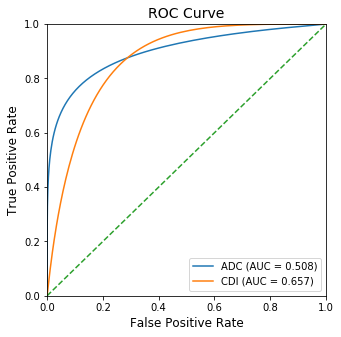

In [7]:
adc_fpr, adc_tpr, adc_auc = plot_roc(x_adc,y_adc_cancer,y_adc_non_cancer)
cdi_fpr, cdi_tpr, cdi_auc = plot_roc(x_cdi,y_cdi_non_cancer,y_cdi_cancer)

#Plotting final ROC curve
plt.figure(figsize=(5,5))
plt.plot(adc_fpr, adc_tpr)
plt.plot(cdi_fpr, cdi_tpr)
plt.plot(adc_fpr, adc_fpr, "--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("ROC Curve", fontsize=14)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(["ADC (AUC = %.3f)"%adc_auc,"CDI (AUC = %.3f)"%cdi_auc], loc = "best")
plt.show()

## Empirically determine ROC
Run the evaluation on different thresholds to generate TPR, FPR pairs and plot those

In [8]:
adc_tpr, adc_fpr, cdi_tpr, cdi_fpr = [],[],[],[]

#test = np.append(np.linspace(x_cdi[50],x_cdi[-81],5),np.linspace(x_cdi[-80],x_cdi[-70],15))

for i, (adc_t, cdi_t) in enumerate(zip(np.linspace(x_adc[50],x_adc[-50],10),np.linspace(x_cdi[50],x_cdi[-70],10))):
    adc_confusion_matrix, cdi_confusion_matrix = evaluate(patients, adc_t, np.exp(cdi_t))

    adc_sensitivity = adc_confusion_matrix[1,1] / (adc_confusion_matrix[1,1] + adc_confusion_matrix[1,0])
    adc_specificity = adc_confusion_matrix[0,0] / (adc_confusion_matrix[0,0] + adc_confusion_matrix[0,1])

    cdi_sensitivity = cdi_confusion_matrix[1,1] / (cdi_confusion_matrix[1,1] + cdi_confusion_matrix[1,0])
    cdi_specificity = cdi_confusion_matrix[0,0] / (cdi_confusion_matrix[0,0] + cdi_confusion_matrix[0,1])
    
    adc_tpr.append(adc_sensitivity)
    adc_fpr.append(1-adc_specificity)
    
    cdi_tpr.append(cdi_sensitivity)
    cdi_fpr.append(1-cdi_specificity)
    print(i+1)

1
2
3
4
5
6
7
8
9
10


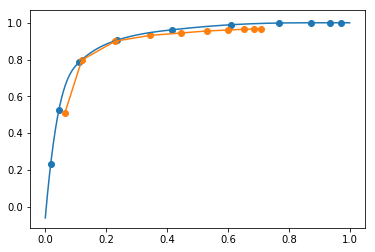

In [9]:
from scipy.interpolate import make_interp_spline, BSpline

plt.scatter(adc_fpr,adc_tpr)
#n = np.linspace(x_adc[50],x_adc[-50],10)
#for i, txt in enumerate(n):
#    plt.annotate('{:.1f}'.format(txt), (adc_fpr[i], adc_tpr[i]))

plt.scatter(cdi_fpr,cdi_tpr)
#n = np.linspace(x_cdi[50],x_cdi[-70],10)
#for i, txt in enumerate(n):
#    plt.annotate('{:.1f}'.format(txt), (cdi_fpr[i], cdi_tpr[i]))

xnew = np.linspace(0, 1, 300)
points = zip(adc_fpr, adc_tpr)
points = sorted(points, key=lambda point: point[0])
x, y = zip(*points)
spl = make_interp_spline(x, y, k=3)  # type: BSpline
smooth = spl(xnew)
plt.plot(xnew,smooth)

plt.plot(cdi_fpr,cdi_tpr)
# CDI pairs do not interpolate well

plt.show()